In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt # plotting
import matplotlib# plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pprint import pprint
import seaborn as sns

## Start by loading in the dataset and remapping a couple of variables to make things nicer.
Put project cost in milllions of $. kWh to MWh. 

**note to self: Not 100\% sure I am interpretting the $Incentive variable correctly at this moment, but it's fine for now **

In [2]:
df = pd.read_csv('data/solar-electric-programs-reported-by-nyserda-beginning-2000.csv', delimiter=',')

#Change Prices to Millions of Dollars
df["Project Cost"] = df["Project Cost"].map(lambda x: x/1000000)
df["Before Incentive Project Cost"] = (df["Project Cost"] - df["$Incentive"]).map(lambda x: x/1000000)

# df["Expected MWh Annual Production"] = df["Expected KWh Annual Production"].map(lambda x: x/1000)

# del df["Expected KWh Annual Production"]

## Strategy:
For this notebook I am going to try and answer why there appears to be a bimodal distribution related to the inverter qty (See previous notebook). Since there are SO many underlying variables to pin down, my strategy will be to cut away projects to get to a controllable sample dataset with sufficient statistics, but will prune out categories that will likely give spurius signals that are impossible to track down. From there I should be able to create higher order variables (custom categories) and perform regression on these. 

*It will be cool to then include the extra categories and see if we can find people who have over/under paid for PPAs.*

# Due to business considerations, look only at Completed projects and PPAs.

In [3]:
print(df.shape)
df = df[df["Purchase Type"] == "Power Purchase Agreement"]
df = df[df["Project Status"] == "Complete"]
# df = df[df["Project Cost"] < 1.3e7]
# df = df[df["Total Inverter Quantity"] < 5]
print(df.shape)


(87329, 31)
(10878, 31)


In [4]:
from utils import countplots 

In [ ]:
countplots(df)

### Looking at the above I think I also should cut out a few more items just to control the number of unknown variables.

This might not work in a more complex dataset. 

In [6]:
#Looking at the above I think I also should cut out a few more items just to control the number of unknown variables.
print(df.shape)
df = df[df["Affordable Solar"] == "No"]
df = df[df["Sector"] == "Residential"]
df = df[df["Community Distributed Generation"] == "No"]
# df = df[df["Project Cost"] < 1.3e7]
# df = df[df["Total Inverter Quantity"] < 5]
print(df.shape)

(10878, 31)
(9949, 31)


In [ ]:
countplots(df)

## Ok so now I'll just get rid of the unnecassary items and focus on the question at hand.
I am also introducing these scaled variabled that come in handy for the non-supervised learning later.

In [8]:
keep_variables = ["Before Incentive Project Cost","Project Cost","Expected KWh Annual Production","Total Inverter Quantity","Total PV Module Quantity","$Incentive","Community Distributed Generation","Solicitation","Sector","Electric Utility","Purchase Type","Primary Inverter Manufacturer"]

thin_df = df[keep_variables].dropna(axis=0)

scaler =  MinMaxScaler()
thin_df["Scaled Project Cost"] = scaler.fit_transform( thin_df["Project Cost"].values.reshape(-1,1) )
thin_df["Scaled Inverter Quantity"] = scaler.fit_transform( thin_df["Total Inverter Quantity"].values.reshape(-1,1) )



In [9]:
from utils import scatterplots

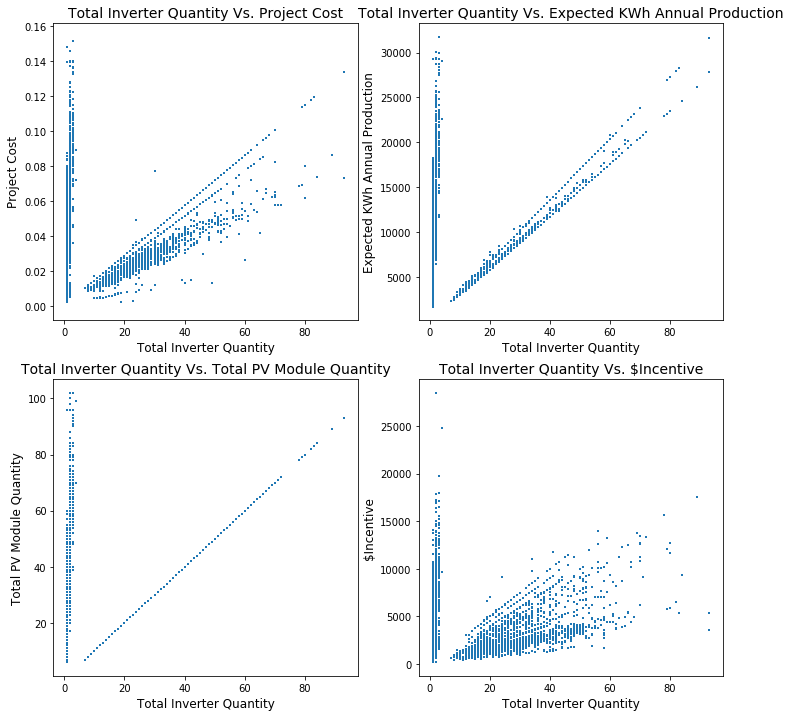

In [10]:
scatterplots(thin_df)
plt.savefig("inverter_scatter.png")
# scatterplots(thin_df,"Project Cost",["Total Inverter Quantity","Expected MWh Annual Production","Total PV Module Quantity","$Incentive"])

# The Inverter Quantity is most seperated when compared to the PV Module Qty.

The goal here should be to use one or more of these plots to find the difference.

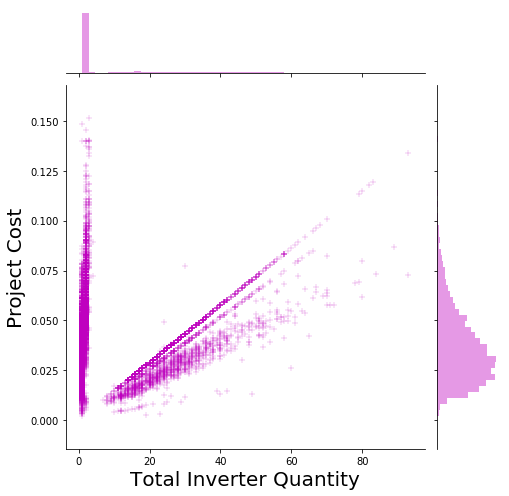

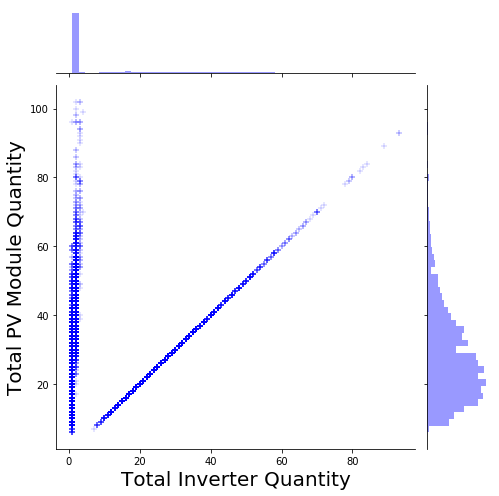

In [11]:
sns.jointplot("Total Inverter Quantity",
                      "Project Cost",data=thin_df,    
                      color="m",
                      height=7, linewidth=0.2,marker="+")

sns.jointplot("Total Inverter Quantity",
                      "Total PV Module Quantity",data=thin_df,    
                      color="b",
                      height=7, linewidth=0.2,marker="+")


# Below I spent a bit of time trying and prototyping, so I will just summarize:
Essentially the cell below is just using some sort of clustering to tease out the two populations the best I could get. I tried many different algorithms and fit a couple different distributions, including multivariate distributions and mapped distributions to a different, more symmetric geometry. 

At the end of the day I use the dbscan algorithm on the Inverter Qty. Vs. PV Module Qty. (2 variables is good enough and easy on memory) to create 3 categories:
Many inverters, few inverters, and outliers. 

In [12]:
#spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
#                           assign_labels='kmeans').fit(thin_df[["Project Cost","Total Inverter Quantity"]])
# kmeans = KMeans(n_clusters=4,init="random",n_init=10,max_iter=300,random_state=0).fit(thin_df[["Project Cost","Total Inverter Quantity"]])
#dbscan = DBSCAN(eps=0.05, min_samples=100,n_jobs=4,leaf_size=200).fit(thin_df[["Scaled Project Cost","Scaled Inverter Quantity"]])#,"$Incentive","Total PV Module Quantity"]])
dbscan = DBSCAN(eps=1.6, min_samples=100,n_jobs=4,leaf_size=200).fit(thin_df[["Total PV Module Quantity","Total Inverter Quantity"]])#,"$Incentive","Total PV Module Quantity"]])

# optics = OPTICS(ne, n_jobs=None).fit(thin_df[["Project Cost","Total Inverter Quantity"]])
# gmm = GaussianMixture(n_components=2,max_iter=30000,covariance_type="full").fit_predict(thin_df[["Project Cost","Total Inverter Quantity","$Incentive","Total PV Module Quantity"]])

In [13]:
# thin_df["Cluster"] = kmeans.labels_
# km = KMeans(
#     n_clusters=3, init='random',
#     n_init=10, max_iter=300, 
#     tol=1e-04, random_state=0
# )
# thin_df["Cluster"] = gmm
#dbscan.predict(df)
thin_df["Cluster"] = dbscan.labels_
np.unique(dbscan.labels_)

array([-1,  0,  1])

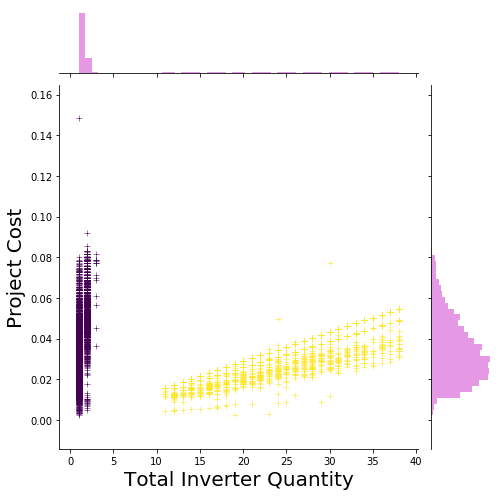

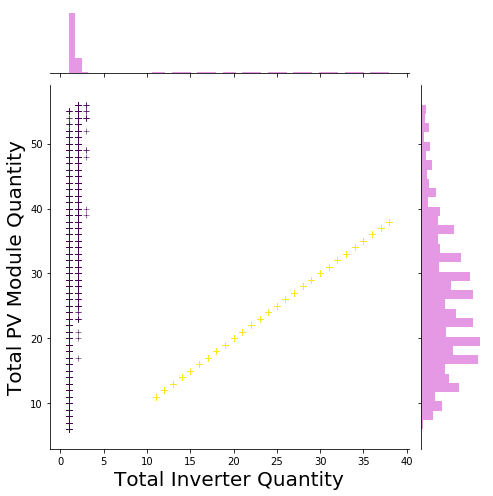

In [14]:
g = sns.jointplot("Total Inverter Quantity","Project Cost",
                  data=thin_df[thin_df["Cluster"]!=-1],
                  color="m", height=7, linewidth=0.0001,marker="+")

g.ax_joint.scatter(thin_df[thin_df["Cluster"]!=-1]["Total Inverter Quantity"],
                   thin_df[thin_df["Cluster"]!=-1]["Project Cost"],
                   c=thin_df[thin_df["Cluster"]!=-1]["Cluster"],
                   linewidth=0.5,marker="+")
plt.show()
plt.savefig("clusters.png")
# g.ax_joint.set_title("Two classes of inverter by Cost")
g = sns.jointplot("Total Inverter Quantity","Total PV Module Quantity",
                  data=thin_df[thin_df["Cluster"]!=-1],
                  color="m", height=7, linewidth=0.0001,marker="+")

g.ax_joint.scatter(thin_df[thin_df["Cluster"]!=-1]["Total Inverter Quantity"],
                   thin_df[thin_df["Cluster"]!=-1]["Total PV Module Quantity"],
                   c=thin_df[thin_df["Cluster"]!=-1]["Cluster"],
                   linewidth=0.5,marker="+")
plt.show()
plt.savefig("clusters.png")
# plt.savefig("clusters.png")

# Above we can clearly see we have seperated the two major categories of inverter styles.

## Now I will plot bar charts for the class 0 which is the "Few Inverters" case

In [ ]:

countable_variables = ["Solicitation","Electric Utility","Primary Inverter Manufacturer"]
# countable_variables = ["Primary Inverter Manufacturer","Solicitation"]


log_scale = ["Solicitation","Primary Inverter Manufacturer"]



plt.rc('axes', labelsize=30)
countplots(thin_df[ thin_df["Cluster"] == 0],countable_variables=countable_variables,log_scale=log_scale,max_categories=7,height=30)
# fig,ax = plt.subplots(2,1)
# fig.set_size_inches(20,15)
# plt.subplot(211)
# p1 = sns.countplot( y="Primary Inverter Manufacturer",data=thin_df[ thin_df["Cluster"] == 0],order=pd.value_counts(df["Primary Inverter Manufacturer"]).iloc[:7].index )
# plt.subplot(212)
# p2 = sns.countplot( y="Primary Inverter Manufacturer",data=thin_df[ thin_df["Cluster"] == 1],order=pd.value_counts(df["Primary Inverter Manufacturer"]).iloc[:7].index )

# plt.savefig("split_inverters.png")

# I don't see anything too strikingly obvious, so lets look at the "Many inverters" case

In [ ]:
countplots(thin_df[ thin_df["Cluster"] == 1],countable_variables=countable_variables,log_scale=log_scale,max_categories=7,height=30)

# Here the solution becomes clear. The "Many Inverters" category seems to come from a single manufacturer: Enphase.
Below I will just make a couple verification plots and summarize. First the "Many Inverters" class then the "Few Inverters". They are both roughly linear in cost and production, and one can tell that the "Many Inverters" class has 1 inverter per PV module. The "Few Inverters" case still has a large spread in the cost per inverter leading me to believe there is a cost optimization possibility. 

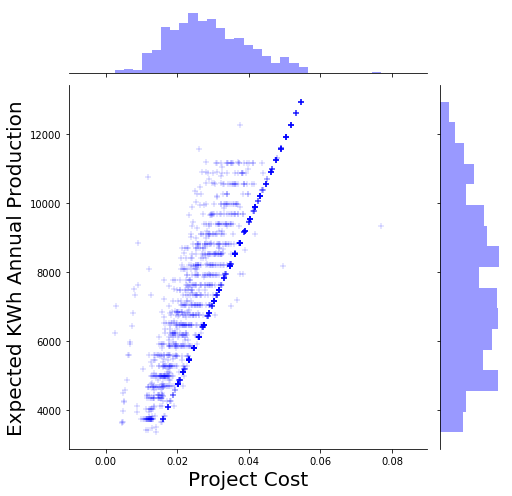

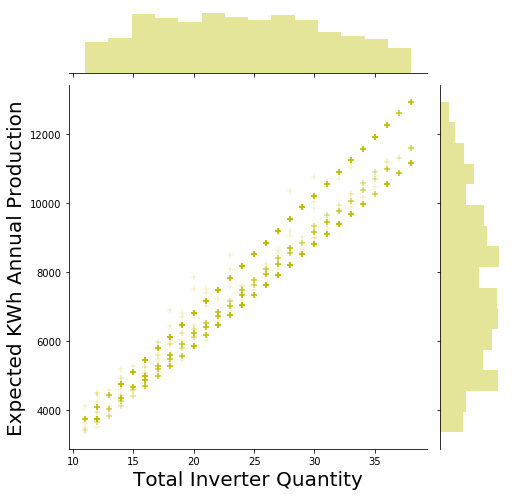

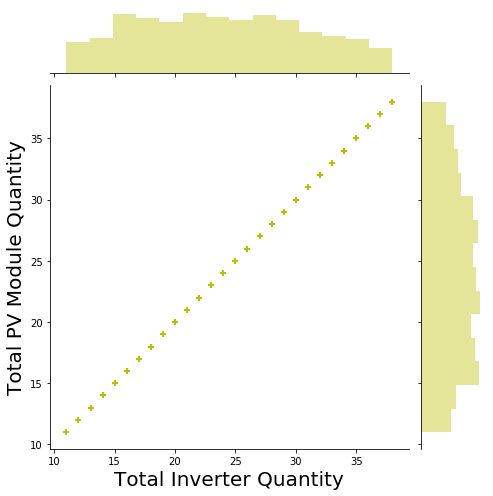

In [17]:
#Enphase inverters
g = sns.jointplot("Project Cost","Expected KWh Annual Production", data=thin_df[ thin_df["Cluster"] == 1], color="b", linewidth=0.2,marker="+", height=7)
# g.ax_joint.set_yscale('log')
# g.ax_joint.set_xlim((0,0.1))
# g.ax_joint.set_ylim((0,30))
g = sns.jointplot("Total Inverter Quantity","Expected KWh Annual Production", data=thin_df[ thin_df["Cluster"] == 1], color="y", linewidth=0.2,marker="+", height=7)
# g.ax_joint.set_yscale('log')
g = sns.jointplot("Total Inverter Quantity","Total PV Module Quantity", data=thin_df[ thin_df["Cluster"] == 1], color="y", linewidth=0.2,marker="+", height=7)



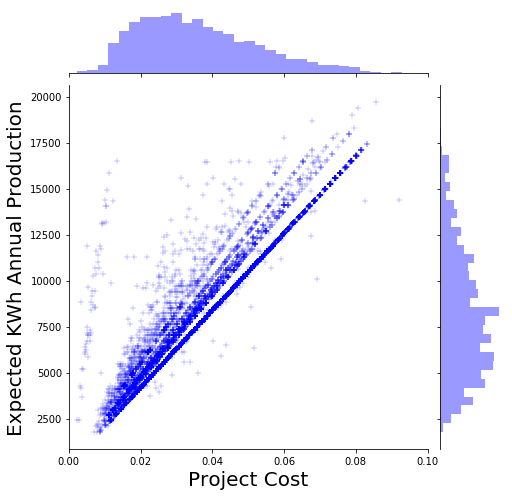

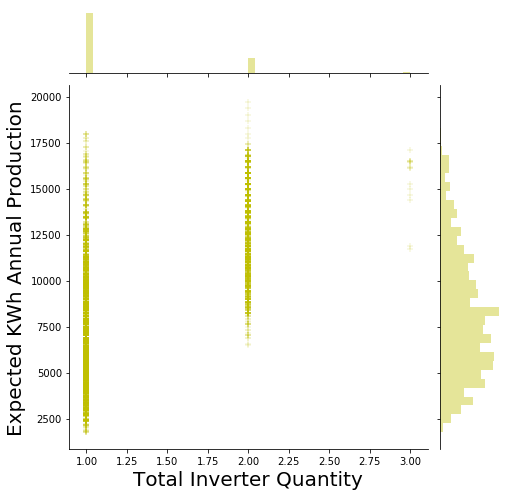

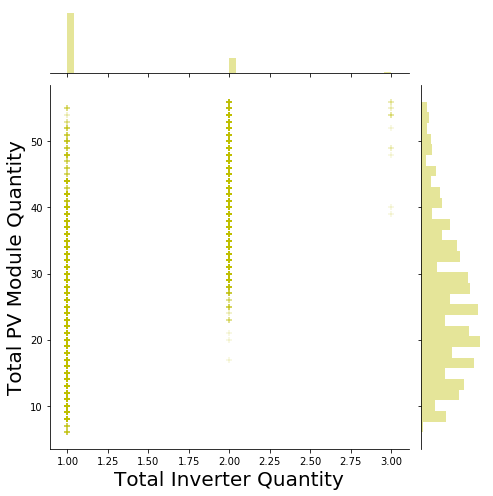

In [18]:
#Other inverters
g = sns.jointplot("Project Cost","Expected KWh Annual Production", data=thin_df[ thin_df["Cluster"] == 0], color="b", linewidth=0.2,marker="+", height=7)
# g.ax_joint.set_yscale('log')
g.ax_joint.set_xlim((0,0.1))
# g.ax_joint.set_ylim((0,30000))
g = sns.jointplot("Total Inverter Quantity","Expected KWh Annual Production", data=thin_df[ thin_df["Cluster"] == 0], color="y", linewidth=0.2,marker="+", height=7)
# g.ax_joint.set_yscale('log')
g = sns.jointplot("Total Inverter Quantity","Total PV Module Quantity", data=thin_df[ thin_df["Cluster"] == 0], color="y", linewidth=0.2,marker="+", height=7)


# Summary

So a quick google shows that Enphase uses micro-inverters, which explains pretty much everything. There is the micro inverter system which uses many smaller inverters and a more traditional system with few large inverters. My data analysis also suggests a perfect 1:1 ratio of inverters to PV modules for Enphase systems, meaning there is an inverter on each PV. 

My guess is that one design is probably superior than the other due to operation and maintanence costs, but I probably won't be able to pull that from this data. Once this feature is unfolded using a clustering algorithm, a linear relationship in Cost and Production is observed for both cases, with still some anomalies. 

It is very interesting that there is a hard boundary in the Project Cost vs. Production scatterplot. There are some people that get a better price, but there is a very definitely linear boundary. Most likely it is a data quality issue and they are recording projections instead of measurements. Data quality is very important! ** Could also be special solicitations? **

Most interestingly it looks like there is a large spread in the "traditional" style of setup which means there is a chance at further modeling. Moving forward the plan should be to seperate the Enphase and ~Enphase cases and then proceed towards regression. 